[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/victwise/fastai_numerical_linear_algebra/blob/master/Cap%C3%ADtulo_2.ipynb)

# Modelando con NMF y SVD

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
np.set_printoptions(suppress=True)

Configurando Datos

In [0]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [21]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [22]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [23]:
newsgroups_train.target

array([1, 3, 2, ..., 1, 0, 1])

In [24]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space', ...,
       'comp.graphics', 'alt.atheism', 'comp.graphics'], dtype='<U18')

In [25]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [0]:
num_topics, num_top_words = 6, 8

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [28]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [29]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [0]:
vocab = np.array(vectorizer.get_feature_names())

In [31]:
vocab.shape

(26576,)

In [32]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

#Descomposición de Valor Singular

In [33]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 51s, sys: 6.9 s, total: 1min 58s
Wall time: 1min


In [34]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


### Ejercicio: confirma que U, s, Vh es una descomposición de las variables vector 

In [35]:
#Obteniendo o creando la diagonal de un vector - np.diag
#np.diag te permite obtener una matriz de un vector, o un vector de una matriz
reconstruyendo_vector = U @ np.diag(s) @  Vh
np.linalg.norm(reconstruyendo_vector - vectors)
np.allclose(reconstruyendo_vector,vectors)

True

###Ejercicio: confirme que U, Vh son ortonormales

In [36]:
#Ortogonales:Multiplicación de sus transposiciones y luego su comparación con su identidad
#np.eye - Devuelve una matriz que tiene 1 en la diagonal y 0 en cualquier otra parte de la matriz
np.allclose(U @ U.T, np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

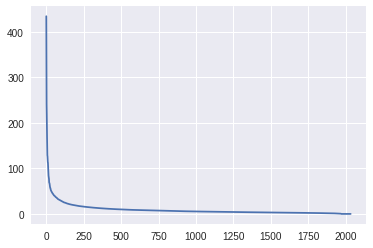

In [37]:
plt.plot(s)

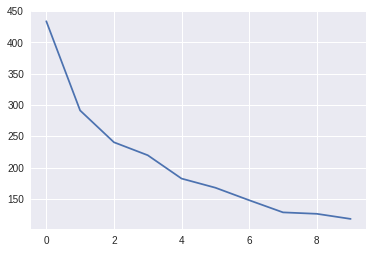

In [38]:
plt.plot(s[:10])

In [0]:
#np.argsort - Devuelve los índices que clasificarían una matriz.
#El método join () proporciona una forma flexible de concatenar strings. 
#Concatena cada elemento de forma iterable (como listas, strings y tuplas) y devuelve el string concatenado.


num_top_words=8


def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [40]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

# Factorización matricial no negativa (NMF)

La factorización de matriz no negativa (FNM) es una factorización no exacta que se basa en una matriz positiva delgada y una matriz positiva corta. NMF es NP-hard y no único. Hay una serie de variaciones en NMF, creadas agregando diferentes restricciones.

In [0]:
n,m=vectors.shape
d=5 #num topics

In [0]:
CLF = decomposition.NMF(n_components=d,random_state=1)

W1 = CLF.fit_transform(vectors)
H1 = CLF.components_

In [45]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

###TF_IDF
La frecuencia de documentos de frecuencia inversa (TF-IDF, por sus siglas en inglés) es una forma de normalizar el recuento de términos teniendo en cuenta la frecuencia con la que aparecen en un documento, la duración del documento y el carácter común/raro del término.

TF = (# recuento del término t en el documento) / (# de palabras en el documento)

IDF = log(# de documentos / # de documentos con el término t en el documento)

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) #(documents,vocab)

In [0]:
W1 = CLF.fit_transform(vectors_tfidf)
H1 = CLF.components_

In [50]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

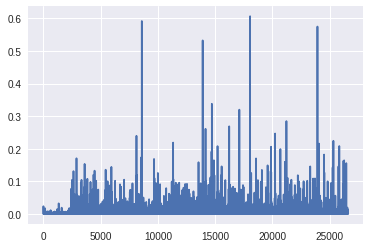

In [51]:
plt.plot(CLF.components_[0])

In [52]:
CLF.reconstruction_err_

43.712926057952785

##NMF usando SGD

Resources:


*   Main: http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/2.%20Topic%20Modeling%20with%20NMF%20and%20SVD.ipynb
*   Norms: https://machinelearningmastery.com/vector-norms-machine-learning/

